The purpose of this project is to analyze a dataset describing a bank's marketing efforts. The dependent variable is a column called y and represents whether or not the call (represented by each row) resulted in a successful sign-up to a term deposit account, which is a relatively conservative financial instrument that guarantees a certain interest rate and allows you to withdraw your cash by the end of the stated period. It provides various details about the potential client at the other end of each call. 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency



In [398]:
df = pd.read_csv('bank-additional-full.csv', sep=';') # The CSV file was not seperated by commas, but by semi-colons, so I chose sep of ;.
df 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# I see that the df has some general demographic data on each potential customer, some information about the finances of the individuals, as well as aspects of the campaign to recruit them. The last few columns are macroeconomic data. This is labeled as new data, not in the original dataset provided. If I have time, I will return to it. My focus is on the individual data.

# I want to see what kind of data I'm working with within each df column. I run a simple for loop to create an easily accessible dictionary to see the unique values in each column.

In [399]:
columns = df.columns 
unique_dict = {}

for c in columns:
    uniques = df[c].unique()
    unique_dict[c] = uniques.tolist()

In [400]:
print(unique_dict['month'])
print(unique_dict['day_of_week'])

['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
['mon', 'tue', 'wed', 'thu', 'fri']


# I checked several columns and decided to make a change to two. I'd like to capitalize the month and day of week values.

In [401]:
df['month'] = df['month'].str.capitalize()
df['day_of_week'] = df['day_of_week'].str.capitalize()

# I want to plot the data by date to see time-series trends. However, the dataset does not label the year. After doing some snooping online, it appears to be from 2008 to 2010, in chronological order. Therefore, the first batch of May months belong to 2008; after June to April is looped over, I know the second May batch is 2009, and so on for all the months. I therefore created several if formulas within a for loop iterating through each df row. It asks if the current row's month euqals the previous row's month. If it does, it is a new group of months. Everytime there's a change in months, I save it in the new_month_indices dictionary.

In [402]:
months = df['month'].unique().tolist()
new_month_indices = {}

for i, row in df.iterrows():
    if i > 0:
        if df.at[i,'month'] != df.at[i-1,'month']:
            month = df.at[i, 'month']
            if month not in new_month_indices:
                index_list = [i]
                new_month_indices[month] = index_list
            else:
                new_month_indices[month].append(i)

In [403]:
new_month_indices

{'Jun': [7763, 36224, 39780],
 'Jul': [12137, 36939, 40009],
 'Aug': [18822, 37117, 40320],
 'Oct': [23997, 38154, 40856],
 'Nov': [24064, 38601, 41060],
 'Dec': [27680, 38958],
 'Mar': [27690, 39130],
 'Apr': [27972, 39394],
 'May': [30430, 39568],
 'Sep': [37887, 40553]}

# Using the data in the new month indices dictionary, I know at what index ecactly do we have a year change. It is in the first month of the dataset after December, March in this case. 

In [404]:
df.loc[0:27688, 'year'] = 2008
df.loc[27689:39128, 'year'] = 2009
df.loc[39129:, 'year'] = 2010

df['year'] = df['year'].astype(int)

# Using the month and year which I created, let's create a month-year date column.

In [405]:
df['month_year'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'] ).dt.to_period('M')

C:\Users\97258\AppData\Local\Temp\ipykernel_34208\3854687989.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month_year'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'] ).dt.to_period('M')


# Let's group the df by the total communications (each row in the df is a unique communication) and the 'y', whether the call was a success in converting the customer. I want to see this as a percentage per month.

In [406]:
total_communications = df.groupby('month_year')['y'].count().reset_index(name='total_communications')
percent_yes = df.groupby('month_year')['y'].apply(lambda x: (x == 'yes').sum() / len(x)).reset_index(name='percent_yes') # I use this lamba to sum all 'yes' outputs for y and divide it over all y's.

yes_grouping = pd.merge(total_communications, percent_yes, on='month_year') # I merge these in order to see the count and conversion rate together in same df
yes_grouping['percent_yes']= yes_grouping['percent_yes']*100

In [407]:
yes_grouping.head(6)

,month_year,total_communications,percent_yes
0,2008-05,7763,3.091588
1,2008-06,4374,4.298125
2,2008-07,6685,6.088257
3,2008-08,5175,5.236715
4,2008-10,67,62.686567
5,2008-11,3616,5.254425


# It's useful to see the total communications per month (the count) and the percent column that we created. This is fortuous because several months have small sample sizes and if we were looking solely at the success percentage, we'd think October 2008 above was some anomolously fantastic month. Let's plot it and see if other months stand out. But first, let's just doublecheck our percentage calc is even correct. We'll take Oct 2008 as an example.

# On to plotting the data by month.

In [408]:
yes_grouping['month_year'] = yes_grouping['month_year'].astype(str) # The data type of month-year was causing me issues in the below plot, so I had to change it to string.


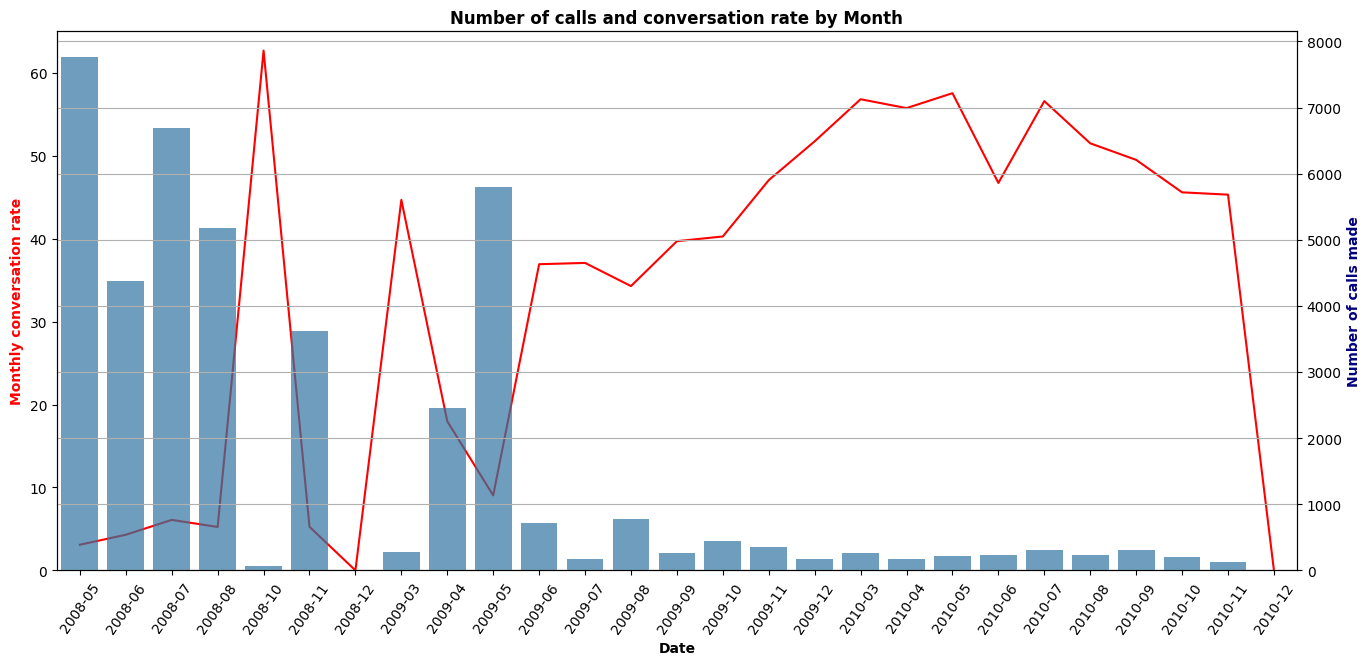

In [409]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(x='month_year',y='percent_yes',data=yes_grouping, color='red', ax=ax)
ax.set_title('Number of calls and conversation rate by Month', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Monthly conversation rate', fontweight='bold', color='red')
ax.set_ylim(0,65)
plt.xticks(rotation=55)

ax2 = ax.twinx()

sns.barplot(x='month_year',y='total_communications',data=yes_grouping, alpha=.7, ax=ax2)
ax2.set_ylabel('Number of calls made', fontweight='bold', color='navy')

plt.grid(True)
plt.show()

# It's hard to draw too many hard conclusions. The months with sample sizes of say below 70 calls vary wildly. Let's disregard those for this analysis. The ones above 70 but below 1,000 seem to have higher rates of success, with conversion rates above 30% than the bars with sample sizes above 1,000 calls. This is suspicious and I'm unsure whether it's possible to jump to conclusions on this basis. It is the case that 2008 and early 2009 had more calls and then the volume drops rather precipitously in June 2009. This can be due simply to incomplete data and not any change in business practices. If I was confident the dataset was complete, the high conversion rate can be an indicator that too many calls have a diminishing rate of return. Another way of conceptualizing it is that the months where the best leads are focused on provide the best ROI. However, it's important to note that 2008 and 2009 saw a financial crisis, which could have caused the low conversion rate from May 2008 to June 2009. I will need to examine the macroeconomic data in a seperate analysis. For the time being, let's continue exploring the data from different angles to see if any of my intuitions here are on the right track.

# First, let's do a demographic breakdown by the main demographic features. For ease, I created a count_table dictionary for every independent variable, grouped by y, the outcome of the calls. I examined several of the independent variable (not all shown) and decided age needed additional exploration for clarity, due to its size.

In [410]:
count_tables = {}

for col in df.columns:
    if col != 'y':
        table = df.groupby(['y', col]).size().reset_index(name='count').sort_values(by=['y', col])
        count_tables[col] = table

In [411]:
print(f'age: {count_tables['age']}')

age:        y  age  count
0     no   17      3
1     no   18     16
2     no   19     22
3     no   20     42
4     no   21     73
..   ...  ...    ...
145  yes   87      1
146  yes   88      9
147  yes   89      2
148  yes   92      3
149  yes   98      2

[150 rows x 3 columns]


# Below I break down the count of each age and the conversion rate in order to plot it. 

In [412]:
total_communications_age = df.groupby('age')['y'].count().reset_index(name='total_communications')
percent_yes_by_age = df.groupby('age')['y'].apply(lambda x: (x == 'yes').sum() / len(x)).reset_index(name='percent_yes') # I use this lamba to sum all 'yes' outputs for y and divide it over all y's.

yes_grouping_age = pd.merge(total_communications_age, percent_yes_by_age, on='age') # I merge these in order to see the count and conversion rate together in same df
yes_grouping_age['percent_yes']= yes_grouping_age['percent_yes']*100

Let's get a preview of the data being plotted:

In [413]:
yes_grouping_age

,age,total_communications,percent_yes
0,17,5,40.000000
1,18,28,42.857143
2,19,42,47.619048
3,20,65,35.384615
4,21,102,28.431373
...,...,...,...
73,91,2,0.000000
74,92,4,75.000000
75,94,1,0.000000
76,95,1,0.000000


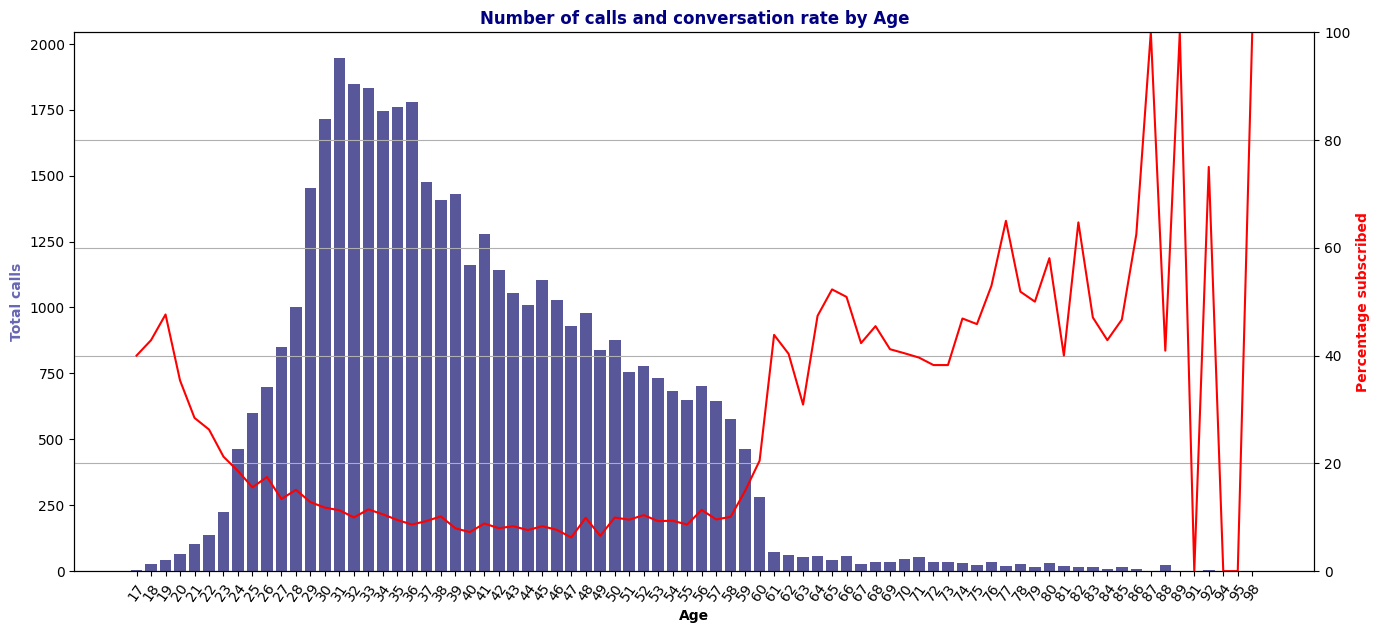

In [505]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='age', y='total_communications', data=yes_grouping_age, alpha=0.7, color='navy', ax=ax)
ax.set_ylabel('Total calls', fontweight='bold', color='navy', alpha=0.6)
ax.set_xlabel('Age', fontweight='bold')
ax.set_title('Number of calls and conversation rate by Age', fontweight='bold', color='navy')
plt.xticks(rotation=55)


ax2 = ax.twinx()
sns.lineplot(x=ax.get_xticks(), y='percent_yes', data=yes_grouping_age, color='red', ax=ax2)
ax2.set_ylabel('Percentage subscribed', fontweight='bold', color='red')
ax2.set_ylim(0, 100)

plt.grid(True)
plt.show()

# This suggests an interesting trend. One thing to note is that ages are more-or-less normally distributed, though based on the visual, the skew is to the right and the distribution seems to be more in the middle (see below for skewness and kurtosis confirmation). Nonetheless, the very young and the very old have fewer samples. What's interesting about that is that the very young and very old have higher conversion rates. The conversation rate starts off high and steadily decreases before stabilizing around age 30 to 35. It then begins to rise again around 59. I think I will split the data into three distinct age groups based on the conversation rate. These three groups will be the basis of the future analysis.

In [414]:
from scipy.stats import skew, kurtosis

# Calculates the skewness and kurtosis for the count of calls made
skewness_total_communications = skew(yes_grouping_age['total_communications'])
kurtosis_total_communications = kurtosis(yes_grouping_age['total_communications'])

print(f"Skewness of 'total_communications': {skewness_total_communications}")
print(f"Kurtosis of 'total_communications': {kurtosis_total_communications}")


Skewness of 'total_communications': 0.8552206089105184
Kurtosis of 'total_communications': -0.5590341187494099


# It isn't perfectly normally distributed. As we could see visually, it skews right (positive) and it has more values in the middle (platykurtic kurtosis)

# Let's the create the age groupings.

In [415]:
bins = [0, 29, 59, float('inf')]  # Specifying the ranges for age groupings
labels = ['young', 'middle-aged', 'old'] # Creating the labels for the groups

df['age_cohort'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [416]:
df.groupby('age_cohort')['age'].count() #As expected, below we see that most calls were made to middle-aged indivduals. Nonetheless, the young and old have big enough sample sizes.

C:\Users\97258\AppData\Local\Temp\ipykernel_34208\1729768975.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_cohort')['age'].count() #As expected, below we see that most calls were made to middle-aged indivduals. Nonetheless, the young and old have big enough sample sizes.


age_cohort
young           4216
middle-aged    35316
old             1656
Name: age, dtype: int64

# Let's see if we can notice trends with other demographic data.

In [418]:
df['y'] = df['y'].map({'no': 0, 'yes': 1}) # Let us take the opportunity to convert y into binary values instead of strings, for easier statistical analysis to come

In [179]:
marital_table = count_tables['marital'] # Using the prior count_tables dict I created, I want to see how marital status impacts the conversion rate.
marital_table

,y,marital,count
0,no,divorced,4136
1,no,married,22396
2,no,single,9948
3,no,unknown,68
4,yes,divorced,476
5,yes,married,2532
6,yes,single,1620
7,yes,unknown,12


# A bit too much data to just eyeball. Let's calculate percentages.

# I need a sum column, then will divide the count column by the sum

In [182]:
total_y_marital = marital_table.groupby('marital')['count'].sum().reset_index(name='sum')
merged_marital = pd.merge(marital_table, total_y_marital, on='marital') # I want the count of each y result with the sum of each individual marital status
merged_marital['percent'] = merged_marital['count']/merged_marital['sum'] # Calculating the percentage
merged_marital


,y,marital,count,sum,percent
0,no,divorced,4136,4612,0.896791
1,yes,divorced,476,4612,0.103209
2,no,married,22396,24928,0.898427
3,yes,married,2532,24928,0.101573
4,no,single,9948,11568,0.859959
5,yes,single,1620,11568,0.140041
6,no,unknown,68,80,0.850000
7,yes,unknown,12,80,0.150000


# Based on the above table results, single individuals appear to be less likely to sign up than married ones and divorced ones alike. It may be worth turning the marital status into a binary of ever_married, grouping the married with the divorcees. The unknowns would be dropped. However, first let's see if marital status is just a proxy for age or if they're independently drivers of y.

In [421]:
marital_mapping = {'divorced': 1,
                  'married':1,
                  'single':0,
                  'unknown':np.nan}

df['ever_married'] = df['marital'].map(marital_mapping)


In [423]:
marital_subset = df.dropna(subset=['ever_married']) #Let's get rid of the unknowns

# Now that we have the df mapped by marital status binarily, with the unknowns dropped, we can analyze the data by grouping age and ever_married together.

In [424]:
total_communications_age_mar = marital_subset.groupby(['age','ever_married','y']).size().unstack().reset_index()

total_communications_age_mar[0] = total_communications_age_mar[0].fillna(0) # Replacing all false y na's with 0
total_communications_age_mar[1] = total_communications_age_mar[1].fillna(0) # Replacing all false y na's with 0


In [425]:
total_communications_age_mar # Let's see the results

y,age,ever_married,0,1
0,17,0.0,3.0,2.0
1,18,0.0,16.0,12.0
2,19,0.0,22.0,20.0
3,20,0.0,41.0,23.0
4,20,1.0,1.0,0.0
...,...,...,...,...
128,91,1.0,2.0,0.0
129,92,1.0,1.0,3.0
130,94,1.0,1.0,0.0
131,95,1.0,1.0,0.0


In [426]:
total_communications_age_mar['percent']= (total_communications_age_mar[1]/(total_communications_age_mar[1]+total_communications_age_mar[0]))*100

In [427]:
total_communications_age_mar

y,age,ever_married,0,1,percent
0,17,0.0,3.0,2.0,40.000000
1,18,0.0,16.0,12.0,42.857143
2,19,0.0,22.0,20.0,47.619048
3,20,0.0,41.0,23.0,35.937500
4,20,1.0,1.0,0.0,0.000000
...,...,...,...,...,...
128,91,1.0,2.0,0.0,0.000000
129,92,1.0,1.0,3.0,75.000000
130,94,1.0,1.0,0.0,0.000000
131,95,1.0,1.0,0.0,0.000000


# After checking the results above, it seems correct. Notice that the ones with values in the 1 column but 0 in the 0 column come out as 100%. This is right. I wanted to avoid div by zero errors. Now let's map it!

C:\Users\97258\AppData\Local\Temp\ipykernel_34208\3520150801.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age',y='percent',hue='ever_married', data=total_communications_age_mar, ci=None)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77],
 [Text(0, 0, '17'),
  Text(1, 0, '18'),
  Text(2, 0, '19'),
  Text(3, 0, '20'),
  Text(4, 0, '21'),
  Text(5, 0, '22'),
  Text(6, 0, '23'),
  Text(7, 0, '24'),
  Text(8, 0, '25'),
  Text(9, 0, '26'),
  Text(10, 0, '27'),
  Text(11, 0, '28'),
  Text(12, 0, '29'),
  Text(13, 0, '30'),
  Text(14, 0, '31'),
  Text(15, 0, '32'),
  Text(16, 0, '33'),
  Text(17, 0, '34'),
  Text(18, 0, '35'),
  Text(19, 0, '36'),
  Text(20, 0, '37'),
  Text(21, 0, '38'),
  Text(22, 0, '39'),
  Text(23, 0, '40'),
  Text(24, 0, '41'),
  Text(25, 0, '42'),
  Tex

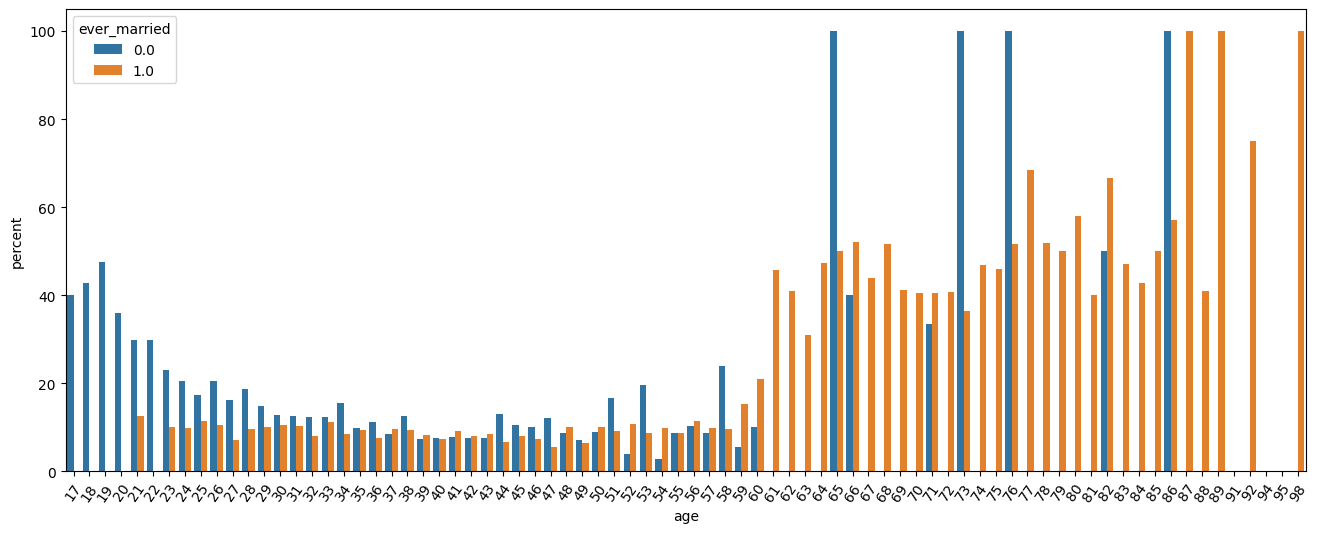

In [428]:
plt.figure(figsize=(16,6))
sns.barplot(x='age',y='percent',hue='ever_married', data=total_communications_age_mar, ci=None)
plt.title('Conversion rate by marital status.')
plt.xticks(rotation=55)


# Remember, a 0 value under the ever_married status indicates they are single. It also has a 15% conversation rate, relatve to 10% for married/divorced individuals. Based on the bars, it appears that the singles (blue bars) trend higher. This is even true among the 21 to the 60 crowd, where there's a mix of both married and single people, unlike the ver young and very old which tend to be largely single in the former case and married/divorced in the latter. Let's look at this more scientifically. Let's normalize the age column from 0 to 1 to match the binary columns.

In [429]:
from sklearn.preprocessing import MinMaxScaler

marital_subset_norm = marital_subset.copy() 

scaler = MinMaxScaler()
marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])

# After normalizing, let us do a logistic regression to see the correlation btwn age & ever_married to y.

In [430]:
import statsmodels.api as sm

X = sm.add_constant(marital_subset_norm[['age','ever_married']])

model_full = sm.Logit(marital_subset_norm['y'],X).fit()


Optimization terminated successfully.
         Current function value: 0.348773
         Iterations 6


In [431]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                41108
Model:                          Logit   Df Residuals:                    41105
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Jan 2024   Pseudo R-squ.:                0.008825
Time:                        12:04:02   Log-Likelihood:                -14337.
converged:                       True   LL-Null:                       -14465.
Covariance Type:            nonrobust   LLR p-value:                 3.640e-56
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.1291      0.038    -56.009      0.000      -2.204      -2.055
age              1.5371      0.129     11.946      0.000       1.285       1.789
ever_married    -0.5511      0.037    -14.928      0.000      -0.623      -0.479
================================================================================
"""

# Let's think of the results above. A coefficient of 1.53 means there's a strong positive correlation between age and y. The older the person, the higher the conversion rate. We already knew that people 60+ have higher conversion rates but so do the very young cohort of 17-29. We will dig into this in the following steps by doing an analysis by age cohort.

# There is a smaller but still large enough negative correlation between being ever_married and y. This is what we expected. However, we will complete our analysis once we dig in by age cohort. 

# In addition, there is a P-value of 0. We can be confident that these results are statistically significant.

In [432]:
marital_subset_norm = marital_subset[(marital_subset['age']>28) & (marital_subset['age']<=59)] #Let's now isolate the middle-aged cohort

scaler = MinMaxScaler()
marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])

X = sm.add_constant(marital_subset_norm[['age','ever_married']])

model_29to59 = sm.Logit(marital_subset_norm['y'],X).fit()

model_29to59.summary()

C:\Users\97258\AppData\Local\Temp\ipykernel_34208\1414062323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])


Optimization terminated successfully.
         Current function value: 0.315133
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                35705
Model:                          Logit   Df Residuals:                    35702
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Jan 2024   Pseudo R-squ.:                0.002260
Time:                        12:10:49   Log-Likelihood:                -11252.
converged:                       True   LL-Null:                       -11277.
Covariance Type:            nonrobust   LLR p-value:                 8.556e-12
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0156      0.037    -54.125      0.000      -2.089      -1.943
age             -0.0704      0.069     -1.022      0.307      -0.206       0.065
ever_married    -0.2721      0.043     -6.374      0.000      -0.356      -0.188
================================================================================
"""

# Looking at the results above, which is the same correlation analysis performed prior but looking at the middle cohort (29 to 59).

# We now see that the age coefficient is very insigificant, slightly negative. The P-value is also 0.307, not above 0.05, and therefore unreliable as a basis to make conclusions on. This is a good result for confirming our expectation, because we expected the age to be positively correlated with conversion after ages approach 60.

# What about ever_married, the variable we want to analyze to see if it has value independent of age? It turns out it does, not hugely negative but due to the low p-value, we can say it's statistically significant. 

In [291]:
# I want to see if the same logic applies to the youngest cohort. Let's analyze. 

marital_subset_norm = marital_subset[(marital_subset['age']>16)&(marital_subset['age']<30)]

scaler = MinMaxScaler()
marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])

X = sm.add_constant(marital_subset_norm[['age','ever_married']])

model_17to29= sm.Logit(marital_subset_norm['y'],X).fit()

model_17to29.summary() 


Optimization terminated successfully.
         Current function value: 0.431903
         Iterations 6


C:\Users\97258\AppData\Local\Temp\ipykernel_34208\1748317387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5660
Model:                          Logit   Df Residuals:                     5657
Method:                           MLE   Df Model:                            2
Date:                Sat, 20 Jan 2024   Pseudo R-squ.:                 0.02758
Time:                        15:47:01   Log-Likelihood:                -2444.6
converged:                       True   LL-Null:                       -2513.9
Covariance Type:            nonrobust   LLR p-value:                 7.654e-31
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5259      0.132     -3.971      0.000      -0.785      -0.266
age             -1.2101      0.172     -7.028      0.000      -1.548      -0.873
ever_married    -0.6886      0.092     -7.457      0.000      -0.870      -0.508
================================================================================
"""

We're interested on the relationship between ever_married and y. As it turns out, it's negatively correlated with a zero P-value. 
It is even more negatively correlated than the same analysis for the 29 to 59 age cohort. 
Let's see the same analysis for the oldest age group.

In [285]:
marital_subset_norm = marital_subset[marital_subset['age']>58]

scaler = MinMaxScaler()
marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])

X = sm.add_constant(marital_subset_norm[['age','ever_married']])

model_59plus= sm.Logit(marital_subset_norm['y'],X).fit()

model_59plus.summary()

Optimization terminated successfully.
         Current function value: 0.600176
         Iterations 5


C:\Users\97258\AppData\Local\Temp\ipykernel_34208\2557870710.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marital_subset_norm['age'] = scaler.fit_transform(marital_subset_norm[['age']])


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1653
Model:                          Logit   Df Residuals:                     1650
Method:                           MLE   Df Model:                            2
Date:                Sat, 20 Jan 2024   Pseudo R-squ.:                 0.05006
Time:                        15:34:35   Log-Likelihood:                -992.09
converged:                       True   LL-Null:                       -1044.4
Covariance Type:            nonrobust   LLR p-value:                 1.978e-23
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.8117      0.335     -5.414      0.000      -2.468      -1.156
age              2.4948      0.255      9.787      0.000       1.995       2.994
ever_married     0.6473      0.335      1.931      0.054      -0.010       1.304
================================================================================
"""

# Interestingly, the ever_married variable is now positively correlated with conversation rate. However, the p-value is borderline, meaning this conclusion may not be reliable. 
# One reason for this may be simply that term deposit accounts are relatively conservative and people with less capital may put their savings there because they have less need for complex financial instruments as they tend to have less capital, even when you divide the combined income in two. However, once you enter the retirement years, all people are conservative because they don't have many years left to risk their savings in the stock market. The conclusion is therefore to focus more on customers who were never married, but only for customers younger than 60.

In [ ]:
# Because I remember most people over 59 were once married and not single, I'd like to see the sample size of the singles to see if this is a completely insignifcant sample. I'd like to see the sample size of the singles for the oldest age cohort to see if this is a completely insignifcant sample.

In [353]:
# over_59 = total_communications_age_mar[total_communications_age_mar['age']>=59]

# print(f'Count of true y\'s: {over_59[1].sum()}\nCount of false y\'s: {over_59[0].sum()}')

Count of true y's: 540.0
Count of false y's: 1113.0


# Exploring socio-economic data below

In [439]:
print(f'education: {count_tables['education']}') # Let's see breakdown by education level

education:       y            education  count
0    no             basic.4y   3748
1    no             basic.6y   2104
2    no             basic.9y   5572
3    no          high.school   8484
4    no           illiterate     14
5    no  professional.course   4648
6    no    university.degree  10498
7    no              unknown   1480
8   yes             basic.4y    428
9   yes             basic.6y    188
10  yes             basic.9y    473
11  yes          high.school   1031
12  yes           illiterate      4
13  yes  professional.course    595
14  yes    university.degree   1670
15  yes              unknown    251


In [440]:
print(f'job: {count_tables['job']}') # Let's see breakdown by job level

job:       y            job  count
0    no         admin.   9070
1    no    blue-collar   8616
2    no   entrepreneur   1332
3    no      housemaid    954
4    no     management   2596
5    no        retired   1286
6    no  self-employed   1272
7    no       services   3646
8    no        student    600
9    no     technician   6013
10   no     unemployed    870
11   no        unknown    293
12  yes         admin.   1352
13  yes    blue-collar    638
14  yes   entrepreneur    124
15  yes      housemaid    106
16  yes     management    328
17  yes        retired    434
18  yes  self-employed    149
19  yes       services    323
20  yes        student    275
21  yes     technician    730
22  yes     unemployed    144
23  yes        unknown     37


# Let us see if job is just a proxy for education by creating a corr matrix which shows the count of values in one category that are present in the second

In [506]:
var2 = 'education'
var1 = 'job'

correlation_matrix = df.groupby([var1, var2]).size().unstack() 
correlation_matrix

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77.0,151.0,499.0,3329.0,1.0,363.0,5753.0,249.0
blue-collar,2318.0,1426.0,3623.0,878.0,8.0,453.0,94.0,454.0
entrepreneur,137.0,71.0,210.0,234.0,2.0,135.0,610.0,57.0
housemaid,474.0,77.0,94.0,174.0,1.0,59.0,139.0,42.0
management,100.0,85.0,166.0,298.0,NaN,89.0,2063.0,123.0
retired,597.0,75.0,145.0,276.0,3.0,241.0,285.0,98.0
self-employed,93.0,25.0,220.0,118.0,3.0,168.0,765.0,29.0
services,132.0,226.0,388.0,2682.0,NaN,218.0,173.0,150.0
student,26.0,13.0,99.0,357.0,NaN,43.0,170.0,167.0


# This is hard to evaluate. We need percentages.

In [507]:
correlation_matrix_percentage = correlation_matrix.div(correlation_matrix.sum(axis=1), axis=0) * 100

correlation_matrix_percentage['Total'] = correlation_matrix_percentage.sum(axis=1)

In [508]:
correlation_matrix_percentage

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown,Total
job,,,,,,,,,
admin.,0.738822,1.448858,4.787949,31.942046,0.009595,3.483017,55.200537,2.389177,100.0
blue-collar,25.048628,15.409553,39.150638,9.487789,0.086449,4.895180,1.015777,4.905987,100.0
entrepreneur,9.409341,4.876374,14.423077,16.071429,0.137363,9.271978,41.895604,3.914835,100.0
housemaid,44.716981,7.264151,8.867925,16.415094,0.094340,5.566038,13.113208,3.962264,100.0
management,3.419973,2.906977,5.677155,10.191518,NaN,3.043776,70.554036,4.206566,100.0
retired,34.709302,4.360465,8.430233,16.046512,0.174419,14.011628,16.569767,5.697674,100.0
self-employed,6.544687,1.759324,15.482055,8.304011,0.211119,11.822660,53.835327,2.040816,100.0
services,3.325775,5.694130,9.775762,67.573696,NaN,5.492567,4.358781,3.779289,100.0
student,2.971429,1.485714,11.314286,40.800000,NaN,4.914286,19.428571,19.085714,100.0


# It looks like there is overlap between occupation and education but not entirely. It nonetheless provides some insights. For example, the self-employed seem to have a similar educational background to entrepreneurs, and a decent amount of both have education levels of basic - 9 years or less.  

# I think it would be best to convert the categories into numeric values and the add the two to create a socio-economic score. This way, we'll get a blended value of the education and job fields.

In [491]:
education_mapping = {'illiterate':1,
    'basic.4y': 2,  
    'basic.6y':3, 
    'basic.9y':4,
    'unknown':4,
    'high.school':5,
    'professional.course':6,
    'university.degree':7}

# Apply the mapping to the 'education' column
df['education_score'] = df['education'].map(education_mapping)

In [492]:
job_mapping = {
    'housemaid': 1,  
    'blue-collar':2, 
    'services':3,
    'unemployed':4,
    'unknown':4,
    'retired':4,
    'student':4.,
    'technician':4,
    'entrepreneur':5,
    'self-employed': 5, 
    'admin.': 6,
    'management': 7}

# Apply the mapping to the 'job' column
df['job_score'] = df['job'].map(job_mapping)

In [493]:
df['socio-economic_score'] = df['job_score']+df['education_score']

In [504]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(df[['socio-economic_score']]
                                    )

socio_correlation, socio_p_value = pointbiserialr(df['socio-economic_score'], df['y'])

print(f'Point-Biserial Correlation - Socio-economic status: {socio_correlation}')
print(f'P-value - Socio-economic status: {socio_p_value}')


Point-Biserial Correlation - Socio-economic status: 0.05975056195639705
P-value - Socio-economic status: 6.745326301713489e-34


# Overall, there's a very insignificant correlation btwn socio-economic status and conversion rate. But maybe some professions are better predictors and things are lost by combining the data?

In [497]:
total_communications = df.groupby('job')['y'].count().reset_index(name='total_communications')
percent_yes = df.groupby('job')['y'].apply(lambda x: (x == 1).sum() / len(x)).reset_index(name='percent_yes')

yes_grouping = pd.merge(total_communications, percent_yes, on='job')
yes_grouping['percent_yes']= yes_grouping['percent_yes']*100

In [500]:
yes_grouping.sort_values(by='percent_yes', ascending=False)

,job,total_communications,percent_yes
8,student,875,31.428571
5,retired,1720,25.232558
10,unemployed,1014,14.201183
0,admin.,10422,12.972558
4,management,2924,11.217510
11,unknown,330,11.212121
9,technician,6743,10.826042
6,self-employed,1421,10.485574
3,housemaid,1060,10.000000
2,entrepreneur,1456,8.516484


# As you can see, students and the retired have high rates of coversion. This can be related to the fact that the young cohort and the older cohort have higher rates in general. The unemployed also have relatively high rates surprisingly. Maybe because CDs are relatively safe (only thing being safer is a savings account), people who invest rather invest in financial instruments that are more-or-less guaranteed and with a set end-date. Beyond that, we see high-status professionals with medium-range sign-up rates. The lower socio-economic groups do have lower sign-ups but so do entrepreneurs, and what's more, housemaids have higher rates than services and blue-collar workers. Overall, it's hard to identify clear trends. It may be advantageous to explore whether unemployment can offer a key to success of campaigns.

# Let's do the same for education levels

In [502]:
total_communications = df.groupby('education')['y'].count().reset_index(name='total_communications')
percent_yes = df.groupby('education')['y'].apply(lambda x: (x == 1).sum() / len(x)).reset_index(name='percent_yes')

yes_grouping = pd.merge(total_communications, percent_yes, on='education')
yes_grouping['percent_yes']= yes_grouping['percent_yes']*100

yes_grouping.sort_values(by='percent_yes', ascending=False)

,education,total_communications,percent_yes
4,illiterate,18,22.222222
7,unknown,1731,14.500289
6,university.degree,12168,13.724523
5,professional.course,5243,11.348465
3,high.school,9515,10.835523
0,basic.4y,4176,10.249042
1,basic.6y,2292,8.202443
2,basic.9y,6045,7.824648


# Again we see odd results. Illiterate people have the highest conversion rate, very surprising. However the sample size is tiny. Those with university degrees have higher rates but the ones with lowest tier education, basic-4 years (other than illiterate), have higher rates than the slightly more educated.

# Let's do some more analysis looking at other variables. Let's see if an existing housing loan or personal loan increases likelihood of signing up to a term deposit account.

In [445]:
df['any_known_loan'] = 0
yes_loans = df[(df['loan']=='yes')|(df['housing']=='yes')]


In [446]:
df.loc[df.index.isin(yes_loans.index), 'any_known_loan'] = 1 # This gives a 1 value to all loans that have either sort of loan


In [447]:
var1 = 'any_known_loan'
var2 = 'y'

correlation_matrix = df.groupby([var1, var2]).size().unstack()
correlation_matrix_percentage = correlation_matrix.div(correlation_matrix.sum(axis=1), axis=0) * 100

any_known_loan_df = pd.concat([correlation_matrix, correlation_matrix_percentage], axis=1, keys=['Count', 'Percentage'])

In [449]:
any_known_loan_df

Count       Percentage           
y                   0     1          0          1
any_known_loan                                   
0               15196  1859  89.099971  10.900029
1               21352  2781  88.476360  11.523640

# Overall, there is a slight trend.with people who have loans also signing up for CDs. I think this may be because people who manage their finances through various financial instruments may be more sophisticated in their finances in general, and are likelier to sign up for multiple programs. Alternatively, they may be more gullible and able to be convinved in financial products by marketers.

In [451]:
var1 = 'contact'
var2 = 'y'

correlation_matrix = df.groupby([var1, var2]).size().unstack()
correlation_matrix_percentage = correlation_matrix.div(correlation_matrix.sum(axis=1), axis=0) * 100

contact_df = pd.concat([correlation_matrix, correlation_matrix_percentage], axis=1, keys=['Count', 'Percentage'])

In [452]:
contact_df

Count       Percentage           
y              0     1          0          1
contact                                     
cellular   22291  3853  85.262393  14.737607
telephone  14257   787  94.768679   5.231321

# There is a very significant difference in breakdown by method of communication. This indicates that calling cell phones is a smarter strategy. Why may this be? It isn't a proxy for age (older people have higher conversion rates but are less likely to use cell phones). It may be because people get telemarketing calls on landlines more often and therefore are skeptical of any calls, wheres people who get called on their cells are likelier to stay on the line.

# Now let's map how the number of communications this campaign affected the conversion rate

In [468]:
x = 'previous'
x2 = 'campaign'

total_communications = df.groupby(x2)['y'].count().reset_index(name='total_communications')
percent_yes = df.groupby(x2)['y'].apply(lambda x: (x == 1).sum() / len(x)).reset_index(name='percent_yes')

yes_grouping = pd.merge(total_communications, percent_yes, on=x2)
yes_grouping['percent_yes']= yes_grouping['percent_yes']*100

In [469]:
yes_grouping

,campaign,total_communications,percent_yes
0,1,17642,13.037071
1,2,10570,11.456954
2,3,5341,10.747051
3,4,2651,9.392682
4,5,1599,7.504690
5,6,979,7.660878
6,7,629,6.041335
7,8,400,4.250000
8,9,283,6.007067
9,10,225,5.333333


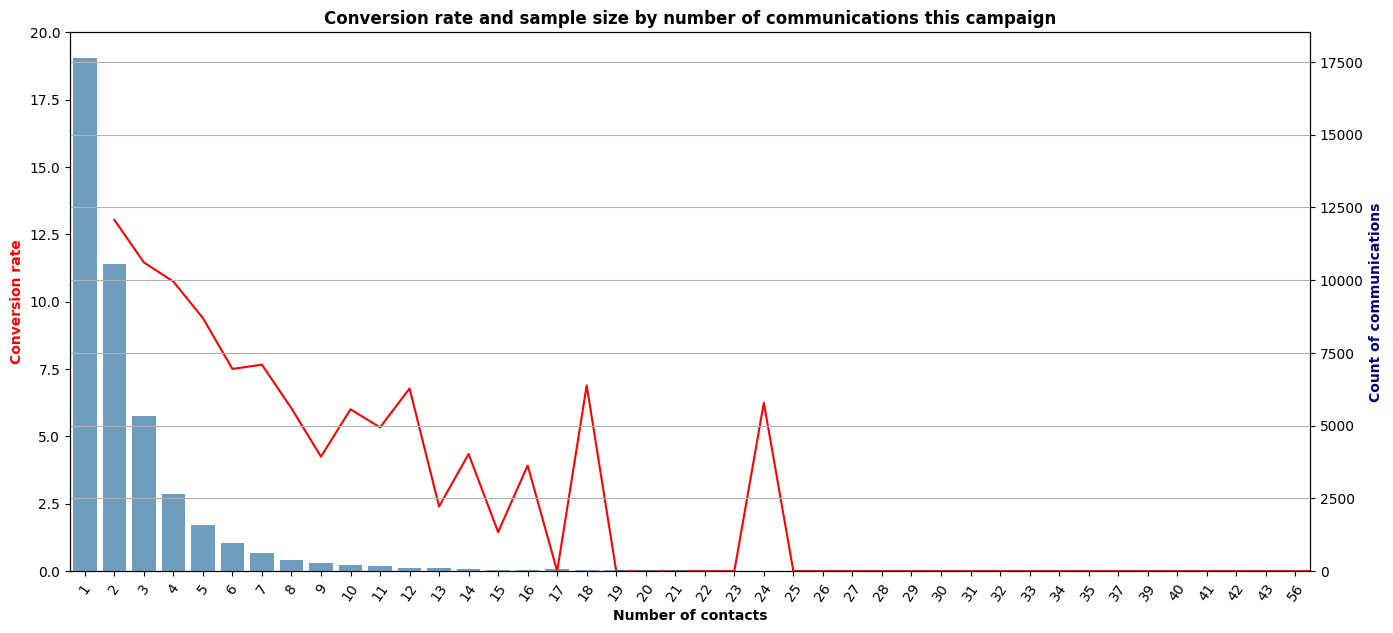

In [470]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(x=x2,y='percent_yes',data=yes_grouping, color='red', ax=ax)
ax.set_title('Conversion rate and sample size by number of communications this campaign', fontweight='bold')
ax.set_xlabel('Number of contacts', fontweight='bold')
ax.set_ylabel('Conversion rate', fontweight='bold', color='red')
ax.set_ylim(0,20)
plt.xticks(rotation=55)

ax2 = ax.twinx()

sns.barplot(x=x2,y='total_communications',data=yes_grouping, alpha=.7, ax=ax2)
ax2.set_ylabel('Count of communications', fontweight='bold', color='navy')

plt.grid(True)
plt.show()



# On one hand, this seems counter-intuitive. Shouldn't more calls result in more conversions? So why do people who only received one call have the highest percentage of conversions and the people who received 56 calls zero? That's because most people either need this service or not. Now some need several reminders, which is why a payoff for calls up to a certain number exists. But there's a drop in marginal return for each subsequent call. There are spikes but these are likely anomolies due to tiny sample sizes in those specific number of contacts. We can fairly confidently that from 18 calls on, there's no added value to continued calls. Definitely not at 56!

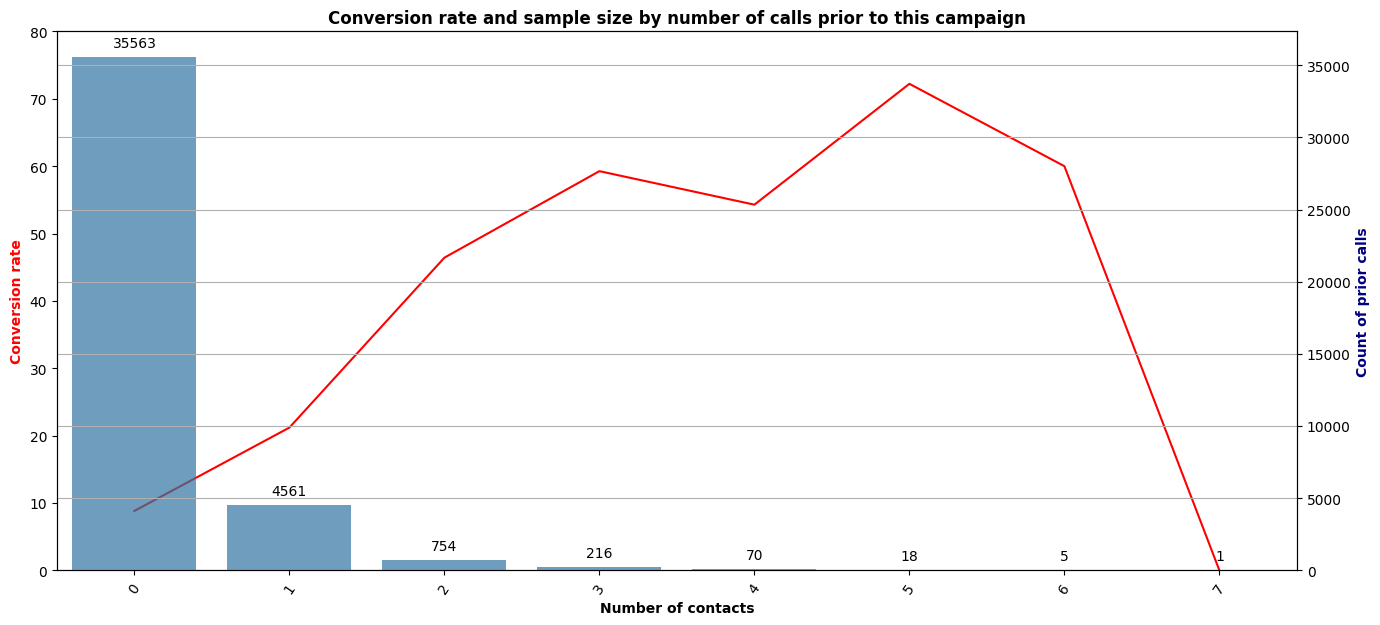

In [473]:
x = 'previous'
x2 = 'campaign'

total_communications = df.groupby(x)['y'].count().reset_index(name='total_communications')
percent_yes = df.groupby(x)['y'].apply(lambda x: (x == 1).sum() / len(x)).reset_index(name='percent_yes')

yes_grouping = pd.merge(total_communications, percent_yes, on=x)
yes_grouping['percent_yes']= yes_grouping['percent_yes']*100


fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(x=x,y='percent_yes',data=yes_grouping, color='red', ax=ax)
ax.set_title('Conversion rate and sample size by number of calls prior to this campaign', fontweight='bold')
ax.set_xlabel('Number of contacts', fontweight='bold')
ax.set_ylabel('Conversion rate', fontweight='bold', color='red')
ax.set_ylim(0,80)
plt.xticks(rotation=55)

ax2 = ax.twinx()

sns.barplot(x=x,y='total_communications',data=yes_grouping, alpha=.7, ax=ax2)
ax2.set_ylabel('Count of prior calls', fontweight='bold', color='navy')

for p in ax2.patches: # Let's label the bar graphs so we can better see what sample size we're dealing with
    ax2.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                 textcoords='offset points')

plt.grid(True)
plt.show()

# What can we gather from this data? For the most part, it seems like following up on prior campaigns is well worth it. The conversion rate keeps increasing, although be warned that everything from 4 prior calls and above has small sample sizes. These really are significant findings. Why may it be the case that the number of contacts in this case helps whereas when looking at the number of contacts within the same campaign, the result seems to be less dramatic? It may be because people need time to learn about the product, internalize that it exists, and only after contemplation be willing to commit in a phone call.

# Let's see how strong the correlation is.

In [474]:
scaler = MinMaxScaler()

df['previous_normalized'] = scaler.fit_transform(df[['previous']])

correlation = df['previous_normalized'].corr(df['y'])

print(f'Correlation between normalized previous and y: {correlation}')

Correlation between normalized previous and y: 0.23018100321659077


# It doesn't seem to be such a strong correlation but I think the above bar chart provides more insights and I do think it's a significant insight.The bank should focus on more people contacted in prior campaigns.

# Let's examine how the outcome of the prior contact affects the outcome this campaign

In [476]:
df['poutcome'].value_counts()

poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

In [477]:
plot_poutcome = df[df['poutcome']!='nonexistent'] #Let's drop the nonexistent prior campaigns, which is the bulk of the df

In [487]:
outcome_mapping = {'success': 1, 'failure': 0}

plot_poutcome['poutcome'] = plot_poutcome['poutcome'].map(outcome_mapping) #We want the values to be binary

C:\Users\97258\AppData\Local\Temp\ipykernel_34208\823877514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_poutcome['poutcome'] = plot_poutcome['poutcome'].map(outcome_mapping) #We want the values to be binary


In [489]:
from scipy.stats import pointbiserialr

scaler = MinMaxScaler()
plot_poutcome.loc[:, 'previous'] = scaler.fit_transform(plot_poutcome[['previous']])

correlation, p_value = pointbiserialr(plot_poutcome['previous'], plot_poutcome['poutcome'])

print(f'Point-Biserial Correlation: {correlation}')
print(f'P-value: {p_value}')


Point-Biserial Correlation: 0.26946813379511836
P-value: 3.545371773610083e-94


# We can see that there isn't a very large correlation between whether the prior campaign resulted in success, but there is some correlation, which backs up the idea that people who engage in financial services are likelier to reengage.

## Summary

#Overall, it is wise for the company to focus on below 29 and above 59 potential customers. The marital status is important and for those under 60, and it is preferable to speak with never-married clients.  Socio-economic status is an imperfect measure of conversion rate, but we do find that university grads/people in administrative and management positions tend to have higher rates, but entrepreneurs and the self-employed don't. There is a huge advantage to calling people on their cells. There is a diminishing return to calls per campaign up to around 10 but following up on prior campaigns, even when not successful, works exceptionally well.